In [1]:
import numpy as np

# fix seed: results of training depend on seed value; typically, one runs several simulations 
# and post-selects the best performance
seed=0 
np.random.seed(seed)

# fix output array
np.set_printoptions(suppress=True,precision=2)

# Deep Policy Gradient (PG)


In this notebook, our goal is to implement the REINFORCE algorithm for policy gradient using [JAX](https://jax.readthedocs.io/en/latest/). 

We will apply this RL algorithm to control a single quantum bit of information (qubit) in the presence of different kinds of noise and spontaneous emission.  

## The REINFORCE Algorithm

The reinforcement learning objective $\mathbf J$ is the expected total return $\mathbf G$, following the policy $\pi$. If the transition probability is denoted by $p(s'|s,a)$, and the initial state distribution is $p(s_0)$, the probability for a trajectory $\tau = (s_0,a_0,r_1,s_1,a_1,\dots,s_{T-1},a_{T-1},r_T,s_T)$ to occur can be written as

$$ 
P_\pi(\tau) = p(s_0)\prod_{t=1}^T \pi(a_t|s_t)p(s_{t+1}|s_t,a_t). 
$$

The RL objective then takes the form

$$
\mathbf J = \mathbb{E}_{\tau\sim P_\pi} \left[ \mathbf G(\tau) | s_{t=0}=s_0 \right],\qquad \mathbf G(\tau)=\sum_{t=1}^T r(s_t,a_t).
$$

Policy gradient methods in RL approximate directly the policy $\pi\approx\pi_\theta$ using a variational ansatz, parametrized by some unknown parameters $\theta$ (e.g., the weights and biases of a neural network). The goal is then to find those optimal parameters $\theta$, which maximize the RL objective $\mathbf J(\theta)$. To define an update rule for $\theta$, we can use gradient ascent. This requires us to evaluate the gradient of the RL objective,
$$
\mathbf J(\theta) = \mathbb{E}_{\tau\sim P_{\pi_\theta}} \left[ \mathbf G(\tau) | s_{t=0}=s_0 \right]
    = \int\mathcal{D}\tau\; P_{\pi_{\theta}}(\tau)\; G(\tau),
$$
w.r.t. the parameters $\theta$.

In a model-free setting, we don't have access to the transition probabilities $p(s'|s,a)$ and this requires us to be able to estimate the gradients from samples. This can be accomplished by noticing that $\nabla_\theta P_{\pi_\theta} = P_{\pi_\theta} \nabla_\theta \log P_{\pi_\theta}$ (almost everywhere, i.e. up to a set of measure zero):

$$
\nabla_\theta \mathbf J(\theta) 
= \nabla_\theta \mathbb{E}_{\tau\sim P_\pi} \left[ \sum_{t=1}^T r(s_t,a_t) | s_{t=0}=s_0 \right] 
= \nabla_\theta \int\mathcal{D}\tau\; P_{\pi_\theta}(\tau)\; \mathbf G(\tau)
= \int\mathcal{D}\tau\; \nabla_\theta P_{\pi_\theta}(\tau)\; \mathbf G(\tau)
= \int\mathcal{D}\tau\; P_{\pi_\theta} \nabla_\theta \log P_{\pi_\theta}\; \mathbf G(\tau)
= \nabla_\theta \mathbb{E}_{\tau\sim P_\pi} \left[ \nabla_\theta \log P_{\pi_\theta}\; \mathbf G \right] .
$$
Since the initial state distribution $p(s_0)$ and the transition probabilities $p(s_{t+1}|s_t,a_t)$ are independent of $\theta$, using the definition of $P_{\pi_\theta}$, we see that $\nabla_\theta \log P_{\pi_\theta}(\tau) = \nabla_\theta \log \pi_\theta(\tau)$ where $\pi_\theta(\tau) = \prod_{t=1}^T \pi_\theta(a_t|s_t)$. 

We can therefore use Monte Carlo sampling to estimate the gradients directly from a sample of trajectories $\{\tau_j\}_{j=1}^N$ using the policy $\pi_\theta(\tau)$:
$$
    \nabla_\theta \mathbf J(\theta) = \mathbb{E}_{\tau\sim P_\pi} \left[\nabla_\theta \log \pi_\theta(\tau)\; \mathbf G(\tau)\right]
    \approx \frac{1}{N}\sum_{j=1}^N \nabla_\theta \log \pi_\theta(\tau_j)\; \mathbf G(\tau_j)
    = \frac{1}{N}\sum_{j=1}^N \left( \sum_{t=1}^T \nabla_\theta\; \pi_\theta(a^j_t|s^j_t) \sum_{t'=1}^T r(a^j_{t'},s^j_{t'}) \right),    
$$
where in the last equality we used $\log \pi_\theta(\tau) = \log \prod_{t=1}^T \pi_\theta(a_t|s_t) = \sum_{t=1}^T \pi_\theta(a^j_t|s^j_t)$, together with the definition of the total return $\mathbf G(\tau)$ above.

To alleviate the problem with the large variance of the gradient estimate, one can introduce a baseline $b=N^{-1}\sum_j \sum_{t'=t}^T r(a^j_{t'}|s^j_{t'})$, defined as the average return over the sample. The policy gradient (PG) update then takes the form

$$
\nabla_\theta \mathbf J(\theta)
\approx \frac{1}{N}\sum_{j=1}^N \sum_{t=1}^T \nabla_\theta \log \pi_\theta(a^j_t|s^j_t) \left[\sum_{t'=t}^T r(a^j_{t'}|s^j_{t'})) - b\right].
$$

One can show that adding this baseline term does not change the expectation value $\nabla_\theta \mathbf J(\theta) = \mathbb{E}_{\tau\sim P_\pi} \left[\nabla_\theta \log \pi_\theta(\tau)\; \mathbf G(\tau)\right]$.

The corresponding gradient *ascent* update rule reads as

$$
\theta \leftarrow \theta + \alpha \nabla_\theta \mathbf J(\theta),
$$
for some step size (or learning rate) $\alpha$. 



## Qubit Environment: Shortcuts to Adiabaticity

Let us define the qubit environment that models the action of gates on the state of the two-level system (2LS). Our goal is to use RL to improve counter-diabatic (CD) driving. To this end, we first use CD theory to determine the operator to which the CD terms couple. However, instead of using the CD protocol, we let the RL agent find the optimal counter drive. 

### Basic Definitions

The state of a qubit $|\psi\rangle\in\mathbb{C}^2$ is modeled by a two-dimensional complex-valued vector with unit norm: $\langle\psi|\psi\rangle:=\sqrt{|\psi_1|^2+|\psi_2|^2}=1$. Every qubit state is uniquely described by two angles $\theta\in[0,\pi]$ and $\varphi\in[0,2\pi)$:

\begin{equation}
|\psi\rangle=
\begin{pmatrix}
\psi_1 \\ \psi_2
\end{pmatrix}=
\mathrm{e}^{i\alpha}
\begin{pmatrix}
\cos\frac{\theta}{2} \\
\mathrm{e}^{i\varphi}\sin\frac{\theta}{2}
\end{pmatrix}
\end{equation}

The overall phase $\alpha$ of a single quantum state has no physical meaning.
Thus, any qubit state can be pictured as an arrow on the unit sphere (called the Bloch sphere) with spherical coordinates $(\theta,\varphi)$. 

To operate on qubits, we use quantum gates. Quantum gates are represented as unitary transformations $U\in \mathrm{U(2)}$, where $\mathrm{U(2)}$ is the unitary group. Gates act on qubit states by matrix multiplication to transform an input state $|\psi\rangle$ to the output state $|\psi'\rangle$: $|\psi'\rangle=U|\psi\rangle.$ 

In quantum platforms, unitary gates are generated by Hamiltonian time evolution. Given an arbitrary time-dependent Hamiltonian $H(t)$, the associated time-evolution operator is given by
\begin{equation}
    U(t,0) = \mathcal{T}_t\exp\left(-i \int_0^t\mathrm d t' H(t')\right),
\end{equation}
where $\mathcal{t}_t\exp$ denotes the time-ordered exponential, and $t$ is the total time the Hamiltonian is applied for. 

For this problem, we consider a two-level system given by the Hamiltonian
\begin{equation}
H(t) = \Delta\sigma^x + \nu(t)\sigma^z,
\end{equation}
where $\Delta$ sets the energy splitting, and the control field $\nu(t)$ couples the two levels. The identity and the Pauli matrices are defined as

\begin{equation}
\boldsymbol{1}=\begin{pmatrix}
1 & 0 \\ 0 & 1
\end{pmatrix}
,\qquad
\sigma^x=\begin{pmatrix}
0 & 1 \\ 1 & 0
\end{pmatrix}
,\qquad
\sigma^y=\begin{pmatrix}
0 & -i \\ i & 0
\end{pmatrix}
,\ \qquad
\sigma^z=\begin{pmatrix}
1 & 0 \\ 0 & -1
\end{pmatrix}.
\end{equation}


### Control Problem

Counter-diabatic driving introduces additional control terms to suppress excitations during the protocol:
\begin{equation}
H_\text{CD}(t) = \Delta\sigma^x + \nu(t)\sigma^z - \frac{1}{2}\frac{\Delta\; \dot\nu(t)}{\Delta^2 + \nu^2(t)}\sigma^y.
\end{equation}
When evolved using $H_\text{CD}(t)$, the system follows the instantaneous eigenstates of the Hamiltonian $H(t)$ at all times. 


We now initialize the system in the ground state of the Hamiltonian $H(0)$ at $\nu_i=+2\Delta$, and want to transfer the population in the ground state at $H(t)$ at $\nu_\ast=-2\Delta$ in a finite amount of time $T$ (referred to as the duration of the protocol). The system is subject to the Hamitlnoan
\begin{equation}
    H_g(t) = \Delta\sigma^x + \nu(t)\sigma^z - g(t)\sigma^y,
\end{equation}
where $\nu(t) = (\nu_\ast-\nu_i)t/T + \nu_i$ is the linear drift term that is always on (and the RL agent has no control over), while $g(t)$ is the unknown counter protocol that we want our RL agent to find.  

To determine if a qubit, described by the state $|\psi\rangle$, is in a desired target state $|\psi_\mathrm{target}\rangle$, we compute the fidelity

\begin{equation}
\mathcal F=|\langle\psi_\mathrm{target}|\psi\rangle|^2 = |(\psi_\mathrm{target})^\ast_1 \psi_1 + (\psi_\mathrm{target})^\ast_2 \psi_2|^2,\qquad \mathcal F\in[0,1]
\end{equation}

where $\ast$ stands for complex conjugation. Physically, the fidelity corresponds to the angle between the arrows representing the qubit state on the Bloch sphere (we want to maximize the fidelity but minimize the angle between the states).

### Constructing the Qubit Environment

Now, let us define an episodic RL environment, which contains the laws of physics that govern the dynamics of the qubit (i.e. the application of the gate operations corresponding to the Hamiltonian evolution to the qubit state). Our RL agent will later interact with this environment to learn how to control the qubit to bring it from an initial state to a prescribed target state (see above). 

We define the RL states $s=(\theta,\varphi)$ as an array containing the Bloch sphere angles of the quantum state. For each timestep of size $\delta t$ within an episode, the agent has to determine the value of the protocol function $g(t)$; to this end, starting from some initial value $g_i$, we let the agent find the optimal relative change in the protocol (i.e., by now much the protocol value has to jump at the given timestep). In practice, we define a minimum protocol size $\delta g$, and consider $2n+1$ steps of size $(-n\delta g, -(n-1)\delta g, \dots, -\delta g, 0,\delta g,\dots, (n-1)\delta g, n\delta g)$ that the agent has to choose from.   

We use the logarithmic fidelity w.r.t. the target state at the end of the protocol 
\begin{equation}
    r_t=-\log_{10}\left(1-\mathcal F\right),\qquad \mathcal F=|\langle\psi_\ast|\psi(T)\rangle|^2,\qquad |\psi(T)\rangle = U(T,0)|\psi_i\rangle,
\end{equation} 
as a reward. The logarithm allows us to learn on a logarithmic scale. Note also that the reward is sparse (i.e., given only at the end of the episode) -- this reflects the character of quantum measurements that collapse the wavefunction. 

**state space:** $\mathbf{S} = \{(\theta,\varphi)|\theta\in[0,\pi],\varphi\in[0,2\pi)\}$. There are no well-defined terminal states in this task. Instead, we consider a fixed number of time steps, after which the episode terminates deterministically. 

**action space:** $\mathbf{A} = \{-n,-(n-1),\cdots,-1,0,1,\cdots,n-1,n\}$. Actions act on RL states as follows: 
1. if the current state is $s=(\theta,\varphi)$, we first create the quantum state $|\psi(s)\rangle$; 
2. we apply the gate $U_a$ corresponding to action $a$ to the quantum state, defined by:
\begin{equation}
    U_a = \exp(-i \delta t H_{a\times\delta g}(n\delta t)),\qquad H_{a\times\delta g}(n\delta t) = \Delta\sigma^x + \nu(n\delta t)\sigma^z - a\times\delta g\sigma^y,
\end{equation}
where $n$ labels the time steps (such the current time is $t=n\delta t$), $a\in\mathbf{A}$, and $\delta g$ is the minimum protocol size.
4. we obtain the new quantum state $|\psi(s')\rangle = U_a|\psi(s)\rangle$. 
5. last, we compute the Bloch sphere coordinates which define the next state $s'=(\theta',\varphi')$, using the Bloch sphere parametrization for qubits given above.
Note that all actions are allowed from every state. 


**reward space:** $\mathbf{R}=[0,+\infty)$. The reward is zero at each step during the protocol: $r_{t<T}=0$, except at the last step, where we use the fidelity between the final state $s_T$ and the target state $s_\ast$ as a reward at the end of every protocol: 

$$r(s,s',a)= r_T = -\log_{10}\left(1-\mathcal F\right),\qquad \mathcal F=|\langle\psi_\ast|\psi(T)\rangle|^2$$

for all states $s,s'\in\mathbf{S}$ and actions $a\in\mathbf{A}$. 

In [2]:
class QubitEnv():
    """
    Gym style environment for RL. You may also inherit the class structure from OpenAI Gym. 
    Parameters:
        n_time_steps:   int
                        Total number of time steps within each episode
        seed:   int
                seed of the RNG (for reproducibility)
    """
    
    def __init__(self, n_time_steps, seed):
        """
        Initialize the environment.
        
        """
        
        self.n_time_steps = n_time_steps
        
        ### define action space variables
        max_action = 10
        self.n_actions = 2*max_action+1 # action space size
        self.action_space=np.linspace(-max_action,+max_action, self.n_actions, dtype=int) 
        self.actions = np.arange(self.n_actions)


        # set model parameters
        self.T = 1.2 # total duration of protocol
        self.dt = self.T/self.n_time_steps # time step
        
        self.Delta=1.0 # splitting
        self.h_init  =+2.0 # initial field value
        self.h_target=-2.0 # target field value
        self.delta_h = (self.h_target-self.h_init)/(max_action*self.n_time_steps)

        # linear ramp
        self.h_t = lambda t: (self.h_target-self.h_init)*t/self.T + self.h_init
        self.h_t_prime = lambda t: (self.h_target-self.h_init)/self.T
        # self.h_t = lambda t: self.h_target*2.0*(-0.5 + np.sin(0.5*np.pi*t/self.T)**2 )
        # self.h_t_prime = lambda t: self.h_target*2.0 * 2.0*(0.5*np.pi/self.T)*np.sin(0.5*np.pi*t/self.T)*np.cos(0.5*np.pi*t/self.T)
        
        # define Pauli matrices
        self.Id     =np.array([[1.0,0.0  ], [0.0 ,+1.0]])
        self.sigma_x=np.array([[0.0,1.0  ], [1.0 , 0.0]])
        self.sigma_y=np.array([[0.0,-1.0j], [1.0j, 0.0]])
        self.sigma_z=np.array([[1.0,0.0  ], [0.0 ,-1.0]])
        
        
        ### define state space variables
        H = lambda h: self.Delta*self.sigma_x + h*self.sigma_z
        # initial states
        E_init,V_init = np.linalg.eigh(H(self.h_init))
        self.psi_init = V_init[:,0]
        # target state
        E_target,V_target = np.linalg.eigh(H(self.h_target))
        self.psi_target = V_target[:,0]
        
        # compute Bloch sphere coordinates
        self.S_target = self.qubit_to_RL_state(self.psi_target)
        
        
        # set seed
        self.set_seed(seed)
        self.reset()
    
    def compute_gate(self, action,):
        """
        Given the action, computes the gate to be applied on the qubit.
        Parameters:
            action: int
                    the index of the respective action in the action array.
        Returns:
            output: np.ndarray
                    unitary matrix encoding the gate operation. 
        """
        
        # drift part of Hamiltonian, always on, ~ sigma_x
        drive = self.h_t(self.dt*self.ep_step) 
        # control part of the Hamiltonian, controlled by RL agent, ~ sigma_y
        self.CD_drive += self.delta_h*self.action_space[action] 
        
        # total angle of rotation = dt x norm of the total external field
        norm = self.dt * np.sqrt(self.Delta**2 + drive**2 + self.CD_drive**2)

        # \exp(-i norm * \vec{n} \dot \vec{\sigma})
        gate = np.cos(norm)*self.Id - 1j*np.sin(norm)*self.dt/norm*(self.Delta * self.sigma_x + 
                                                                    drive * self.sigma_z - 
                                                                    self.CD_drive * self.sigma_y
                                                               )
        return gate
    
    def step(self, action):
        """
        Interface between environment and agent. Performs one step in the environemnt.
        Parameters:
            action: int
                    the index of the respective action in the action array
        Returns:
            output: (object, float, bool)
                    information provided by the environment about its current state:
                    (state, reward, done)
        """

        # apply gate to quantum state
        gate = self.compute_gate(action)
        
        # apply unitary
        self.psi = gate.dot(self.psi)
        
        # compute RL state
        self.state = self.qubit_to_RL_state(self.psi)
        
        self.ep_step+=1 # increment step

        # compute reward
        if self.ep_step == self.n_time_steps:
            #reward = np.abs( self.psi_target.conj().dot(self.psi)  )**2
            reward = -np.log10( 1.0 - np.abs( self.psi_target.conj().dot(self.psi)  )**2 )
        else:
            reward = 0.0

        
        # check if state is terminal
        done=False
        
        return self.state, reward, done

    
    
    def set_seed(self,seed=0):
        """
        Sets the seed of the RNG.
        
        """
        np.random.seed(seed)
    
    
    
    def reset(self, ):
        """
        Resets the environment to its initial values.
        Returns:
            state:  object
                    the initial state of the environment
            random: bool
                    controls whether the initial state is a random state on the sphere or a fixed initial state.
        """
        self.ep_step=0 # reset step coutner
        self.CD_drive = 0.5*self.Delta * self.h_t_prime(self.dt*self.ep_step) / (self.Delta**2 + (self.h_t(self.dt*self.ep_step))**2) # -0.33
        
        self.psi=self.psi_init[:]
        self.state=self.qubit_to_RL_state(self.psi)

        return self.state

    
    
    def render(self):
        """
        Plots the state of the environment. For visulization purposes only. Feel free to ignore. 

        """
        pass
    
    
    def RL_to_qubit_state(self,s):
        """
        Take as input the RL state s, and return the quantum state |psi>
        """
        theta, phi = s
        psi = np.array([np.cos(0.5*theta), np.exp(1j*phi)*np.sin(0.5*theta)] )
        return psi
    
    
    def qubit_to_RL_state(self,psi):
        """
        Take as input the RL state s, and return the quantum state |psi>
        """
        # take away unphysical global phase
        alpha = np.angle(psi[0])
        psi_new = np.exp(-1j*alpha) * psi 
        
        # find Bloch sphere angles
        theta = 2.0*np.arccos(psi_new[0]).real
        phi = np.angle(psi_new[1])
        
        return np.array([theta, phi])

Let us test how the qubit environment works.

In [3]:
# set seed of rng (for reproducibility of the results)
n_time_steps = 40 # steps of each episode

# create environment and reset it to a random initial state
env=QubitEnv(n_time_steps,seed)
env.reset()

done=False
j=0
while j < n_time_steps:
    
    # pick a random action
    action=np.random.choice(env.actions) # equiprobable policy
    
    # take an environment step
    state=env.state.copy()
    state_p, reward, done = env.step(action)
    
    print("{}. s={}, a={}, r={}, s'={}\n".format(j, state, action, np.round(reward,6), state_p))
    
    j+=1
    
    if done:
        print('\nreached terminal state!')
        break

0. s=[2.68 3.14], a=12, r=0.0, s'=[ 2.66 -3.14]

1. s=[ 2.66 -3.14], a=15, r=0.0, s'=[ 2.63 -3.14]

2. s=[ 2.63 -3.14], a=0, r=0.0, s'=[ 2.62 -3.13]

3. s=[ 2.62 -3.13], a=3, r=0.0, s'=[ 2.6  -3.13]

4. s=[ 2.6  -3.13], a=3, r=0.0, s'=[ 2.59 -3.14]

5. s=[ 2.59 -3.14], a=7, r=0.0, s'=[2.58 3.14]

6. s=[2.58 3.14], a=9, r=0.0, s'=[2.58 3.13]

7. s=[2.58 3.13], a=19, r=0.0, s'=[2.56 3.11]

8. s=[2.56 3.11], a=18, r=0.0, s'=[2.54 3.1 ]

9. s=[2.54 3.1 ], a=4, r=0.0, s'=[2.53 3.08]

10. s=[2.53 3.08], a=6, r=0.0, s'=[2.51 3.06]

11. s=[2.51 3.06], a=12, r=0.0, s'=[2.49 3.03]

12. s=[2.49 3.03], a=1, r=0.0, s'=[2.48 3.  ]

13. s=[2.48 3.  ], a=6, r=0.0, s'=[2.46 2.97]

14. s=[2.46 2.97], a=7, r=0.0, s'=[2.45 2.94]

15. s=[2.45 2.94], a=14, r=0.0, s'=[2.43 2.9 ]

16. s=[2.43 2.9 ], a=17, r=0.0, s'=[2.4  2.86]

17. s=[2.4  2.86], a=5, r=0.0, s'=[2.38 2.82]

18. s=[2.38 2.82], a=13, r=0.0, s'=[2.35 2.78]

19. s=[2.35 2.78], a=8, r=0.0, s'=[2.32 2.73]

20. s=[2.32 2.73], a=9, r=0.0, s'=[2.29 2.

Let us now define the exact CD protocol

In [4]:
exact_CD_protocol = lambda t: 0.5 * env.h_t_prime(t) / (env.Delta**2 + env.h_t(t)**2)

Next, we find the best approximation to the exact CD protocol, within the available action space. 

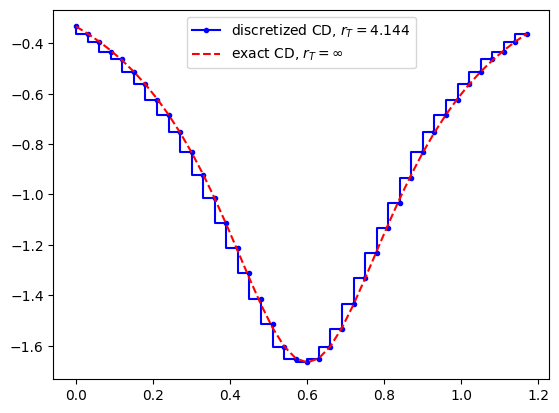

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# reset environment
env.reset()
# preallocate arrays for approximate CD actions and the approximate CD protocol
CD_actions_t = np.zeros(env.n_time_steps, dtype=int)
CD_protocol_t = np.zeros(env.n_time_steps,)

for time_step in range(env.n_time_steps):

    # construct exact CD drive
    drive = env.h_t(env.dt*time_step)
    CD_drive = 0.5*env.Delta * env.h_t_prime(env.dt*time_step) / (env.Delta**2 + drive**2)

    # find action that gives closes value to theory CD protocol
    action = np.argmin( np.abs(env.CD_drive + env.delta_h*env.action_space - CD_drive) )
    
    # take an environment step with approximate CD action
    state[:], reward, _ = env.step(action)
    # compute instantaneous fidelity
    fidelity = np.abs( env.psi_target.conj().dot(env.psi)  )**2 

    # record approximate CD action and protocol
    CD_actions_t[time_step] = action
    CD_protocol_t[time_step]=env.CD_drive    

# store reward
reward_CD_approx = reward

# plot approximate CD protocol
times = np.arange(env.n_time_steps)*env.dt
plt.step(times, CD_protocol_t, '.-b', where='pre', label='discretized CD, $r_T={0:0.3f}$'.format(reward_CD_approx) )
plt.plot(times, exact_CD_protocol(times),'--r', label='exact CD, $r_T=\infty$' )
plt.legend()
plt.show()

## Policy Gradient Implementation

The implementation of the PG algorithm proceeds as follows:

1. Define the a SoftMax model for the discrete policy $\pi_\theta$.
2. Define the pseudo loss function to easily compute $\nabla_\theta J(\theta)$.
3. Define generalized gradient descent optimizer.
4. Define the PG training loop and train the policy.

*Note:* if you are familiar with solving the MNIST problem, you will recognize many of the steps used to construct and train the neural network. What is different here is the training algorithm.

### Define a SoftMax model for the discrete policy $\pi_\theta$

Use JAX to construct a feed-forward fully-connected deep neural network with neuron acrchitecture $(M_s, 512, |\mathcal{A}|)$, where there are $512$ ($256$) neurons in the first (second) hidden layer, respectively, and $M_s$ and $|\mathcal{A}|$ define the input and output sizes.

The input data into the neural network should have the shape `input_shape = (-1, n_time_steps, M_s)`, where `M_s` is the number of features/components in the RL state $s=(\theta,\varphi)$. The output data should have the shape `output_shape = (-1, n_time_steps, abs_A)`, where `abs_A`$=|\mathcal{A}|$. In this way, we can use the neural network to process simultaneously all time steps and MC samples, generated in a single training iteration. 

Check explicitly the output shape and test that the network runs on some fake data (e.g. a small batch of vectors of ones with the appropriate shape). 

In [6]:
import jax.numpy as jnp # jax's numpy version with GPU support
from jax import random # used to define a RNG key to control the random input in JAX
from jax.example_libraries import stax # neural network library
from jax.example_libraries.stax import Dense, Relu, LogSoftmax # neural network layers

# set key for the RNG (see JAX docs)
rng = random.PRNGKey(seed)

# define functions which initialize the parameters and evaluate the model
initialize_params, predict = stax.serial(
                                            ### fully connected DNN
                                            Dense(512), # 512 hidden neurons
                                            Relu,
                                            #Dense(256), # 256 hidden neurons
                                            #Relu,
                                            #Dense(128), # 128 hidden neurons
                                            #Relu,
                                            Dense(env.n_actions), # 4 output neurons
                                            LogSoftmax # NB: computes the log-probability
                                        )

# initialize the model parameters
input_shape = (-1,env.n_time_steps,2) # -1: number of MC points, number of time steps, size of state vector
output_shape, inital_params = initialize_params(rng, input_shape) # fcc layer 28x28 pixes in each image

print('\noutput shape of the policy network is {}.\n'.format(output_shape))


# test network
states=np.ones((3,env.n_time_steps,2), dtype=np.float32)

predictions = predict(inital_params, states)
# check the output shape
print(predictions.shape)


output shape of the policy network is (-1, 40, 21).

(3, 40, 21)


### Define the pseudo loss function to easily compute $\nabla_\theta J(\theta)$

REINFORCE allows to define a scalar pseudoloss function, whose gradients give $\nabla_\theta J(\theta)$. Note that this pseudoloss does ***NOT*** correspond to the RL objective $J(\theta)$: the difference stems from the fact that the two operations of taking the derivative and performing the MC approximation are not interchangeable (do you see why?).  

$$
J_\mathrm{pseudo}(\theta) = 
\frac{1}{N}\sum_{j=1}^N \sum_{t=1}^T 
\log \pi_\theta(a^j_t|s^j_t) 
\left[
\sum_{t'=t}^T \left(r(a^j_{t'}|s^j_{t'}) - b_t \right)
-\frac{\beta^{-1}}{2}\sum_{t'=1}^T \log \pi_\theta(a^j_{t'}|s^j_{t'}) 
\right],\qquad 
b_t = \frac{1}{N}\sum_{j=1}^N G_t(\tau_j).
$$
The baseline is a sample average of the reward-to-go (return) from time step $t$ onwards: $G_t(\tau_j) = \sum_{t'=t}^T r(s^j_{t'},s^j_{t'})$ .

Because we will be doing gradient **a**scent, do **NOT** forget to add an extra minus sign to the output ot the pseudoloss (or else your agent will end up minimizing the return). 

Below, we also add an L2 regularizer to the pseudoloss function to prevent overfitting. 

In [7]:
### define loss and accuracy functions

from jax import grad
from jax.tree_util import tree_flatten # jax params are stored as nested tuples; use this to manipulate tuples


def l2_regularizer(params,lmbda=1E-3):
    """
    Define l2 regularizer: $\lambda \ sum_j ||theta_j||^2 $ for every parameter in the model $\theta_j$
    
    """
    return lmbda*jnp.sum(jnp.array([jnp.sum(jnp.abs(theta)**2) for theta in tree_flatten(params)[0] ]))

def policy_entropy_pseudo_loss(preds_select,beta_inv=1E-1):
    ent_max = env.n_time_steps*jnp.log(env.n_actions)
    return -beta_inv*0.5*jnp.sum(preds_select,axis=1)**2 / ent_max

def policy_pseudo_loss(preds_select,returns,baseline):
    #return jnp.sum(preds_select * (returns - baseline), axis=1)
    return jnp.sum(preds_select * (returns - baseline), axis=1)

def pseudo_loss(params, trajectory_batch):
    """
    Define the pseudo loss function for policy gradient. 
    
    params: object(jax pytree):
        parameters of the deep policy network.
    trajectory_batch: tuple (states, actions, returns) containing the RL states, actions and returns (not the rewards!): 
        states: np.array of size (N_MC, env.n_time_steps,2)
        actions: np.array of size (N_MC, env.n_time_steps)
        returns: np.array of size (N_MC, env.n_time_steps)
    
    Returns:
        -J_{pseudo}(\theta)

    """
    # extract data from the batch
    states, actions, returns = trajectory_batch
    # compute policy predictions
    preds = predict(params, states)
    # combute the baseline
    baseline = jnp.mean(returns, axis=0)
    # select those values of the policy along the action trajectory
    preds_select = jnp.take_along_axis(preds, jnp.expand_dims(actions, axis=2), axis=2).squeeze()
    # return negative pseudo loss function (want to maximize reward with gradient DEscent)
    return -jnp.mean(policy_pseudo_loss(preds_select,returns,baseline) + policy_entropy_pseudo_loss(preds_select)) + l2_regularizer(params)


### Define generalized gradient descent optimizer

Define the optimizer and the `update` function which computes the gradient o the pseudo-loss function and performs the update. 

We use the Adam optimizer here with `step_size = 0.001` and the rest of the parameters have default values. 

In [8]:
### define generalized gradient descent optimizer and a function to update model parameters

from jax.example_libraries import optimizers # gradient descent optimizers
from jax import jit

step_size = 0.001 # step size or learning rate 

# compute optimizer functions
opt_init, opt_update, get_params = optimizers.adam(step_size)


# define function which updates the parameters using the change computed by the optimizer
@jit # Just In Time compilation speeds up the code; requires to use jnp everywhere; remove when debugging
def update(i, opt_state, batch):
    """
    i: int,
        counter to count how many update steps we have performed
    opt_state: object,
        the state of the optimizer
    batch: np.array
        batch containing the data used to update the model
        
    Returns: 
    opt_state: object,
        the new state of the optimizer
        
    """
    # get current parameters of the model
    current_params = get_params(opt_state)
    # compute gradients
    grad_params = grad(pseudo_loss)(current_params, batch)
    # use the optimizer to perform the update using opt_update
    return opt_update(i, grad_params, opt_state)

### Define the PG training loop and train the policy

Finally, we implement the REINFORCE algorithm for policy gradient. 

Follow the steps below:

1. Preallocate variables
    * Define the number of episodes `N_episodes`, and the batch size `N_MC`.
    * Preallocate arrays for the current `state`, and the `states`, `actions`, `returns` triple which defines the trajectory batch. 
    * Preallocate arrays to compute the `mean_final_reward`, `std_final_reward`, `min_final_reward`, and , `max_final_reward`.
2. Initialize the optimizer using the `opt_init` function. 
3. Loop over the episodes; for every episode:

    3.1 get the current Network parameters
    
    3.2 loop to collect MC samples
        
      3.2.1 reset the `env` and roll out the policy until the episode is over; collect the trajectory data
    
      3.2.2 compute the returns (rewards to go)
    
    3.3 compile the PG data into a trajectory batch
    
    3.4 use the `update` function to update the network parameters
    
    3.5 print instantaneous performance

***Note*** that training can take a considerably long time with the default hyperparameters. 

***Note*** also that, despite fixing the seed of the random number generator, you may not be able to reproduce *precisely* the same plots from the paper since different architectures use different arithmetic instructions.  

In [9]:
### Train model
import time

# define number of training episodes
N_episodes = 1001 #10001 # total number of training episodes
N_MC = 256 # number of trajectories in the batch


# preallocate data using arrays initialized with zeros
state=np.zeros((2,), dtype=np.float32)
    
states = np.zeros((N_MC, env.n_time_steps,2), dtype=np.float32)
actions = np.zeros((N_MC, env.n_time_steps), dtype=np.int64)
returns = np.zeros((N_MC, env.n_time_steps), dtype=np.float32)
    
# mean reward at the end of the episode
mean_final_reward = np.zeros(N_episodes, dtype=np.float32)
# standard deviation of the reward at the end of the episode
std_final_reward = np.zeros_like(mean_final_reward)
# batch minimum at the end of the episode
min_final_reward = np.zeros_like(mean_final_reward)
# batch maximum at the end of the episode
max_final_reward = np.zeros_like(mean_final_reward)
# best-seen trajectory
RL_best_seen_actions = np.zeros(env.n_time_steps, dtype=int)
max_return_ever=-100.0

print("\nStarting training...\n")

# set the initial model parameters in the optimizer
opt_state = opt_init(inital_params)

# loop over the number of training episodes
for episode in range(N_episodes): 
    
    ### record time
    start_time = time.time()
    
    # get current policy  network params
    current_params = get_params(opt_state)
    
    # MC sample
    for j in range(N_MC):
        
        # reset environment to a random initial state
        #env.reset(random=False) # fixed initial state
        env.reset() # Haar-random initial state (i.e. uniformly sampled on the sphere)
    
        # zero rewards array (auxiliary array to store the rewards, and help compute the returns)
        rewards = np.zeros((env.n_time_steps, ), dtype=np.float32)
    
        # loop over steps in an episode
        for time_step in range(env.n_time_steps):

            # select state
            state[:] = env.state[:]
            states[j,time_step,:] = state

            # select an action according to current policy
            pi_s = np.exp( predict(current_params, state) )
            #print('policy:', pi_s )
            action = np.random.choice(env.actions, p = pi_s)
            actions[j,time_step] = action

            # take an environment step
            state[:], reward, _ = env.step(action)

            # store reward
            rewards[time_step] = reward
            
            
        # compute reward-to-go 
        returns[j,:] = jnp.cumsum(rewards[::-1])[::-1]
        
        
            
    # define batch of data
    trajectory_batch = (states, actions, returns)

    # check size of losses
    preds = predict(current_params, states)
    # combute the baseline
    baseline = jnp.mean(returns, axis=0)
    # select those values of the policy along the action trajectory
    preds_select = jnp.take_along_axis(preds, jnp.expand_dims(actions, axis=2), axis=2).squeeze()
    # return negative pseudo loss function (want to maximize reward with gradient DEscent)
    print('loss comparison', -jnp.mean(policy_pseudo_loss(preds_select,returns,baseline)), -jnp.mean(policy_entropy_pseudo_loss(preds_select)),  l2_regularizer(current_params) )

    
    # update model
    opt_state = update(episode, opt_state, trajectory_batch)
            
    ### record time needed for a single epoch
    episode_time = time.time() - start_time
    
    # check performance
    mean_final_reward[episode]=jnp.mean(returns[:,-1])
    std_final_reward[episode] =jnp.std(returns[:,-1])
    min_final_reward[episode], max_final_reward[episode] = np.min(returns[:,-1]), np.max(returns[:,-1])
    ind_max = np.argmax(returns[:,-1])
    if max_final_reward[episode] > max_return_ever:
        RL_best_seen_actions[:] = actions[ind_max,:]
        max_return_ever = max_final_reward[episode]
        print("new optimal trajectory encountered:")

    
    # print results every 10 epochs
    #if episode % 5 == 0:
    print("episode {} in {:0.2f} sec".format(episode, episode_time))
    print("mean reward: {:0.6f}".format(mean_final_reward[episode]) )
    print("return standard deviation: {:0.6f}".format(std_final_reward[episode]) )
    print("min return: {:0.6f}; max return: {:0.6f}\n".format(min_final_reward[episode], max_final_reward[episode]) )
    print("max ever return: {0:0.6f}".format(max_return_ever) )


Starting training...

loss comparison -0.047066927 5.959206 0.045099996
new optimal trajectory encountered:
episode 0 in 2.71 sec
mean reward: 0.560048
return standard deviation: 0.251699
min return: 0.192190; max return: 1.721746

max ever return: 1.721746
loss comparison -0.09422326 5.9626207 0.044904936
episode 1 in 1.61 sec
mean reward: 0.609364
return standard deviation: 0.252082
min return: 0.192480; max return: 1.627664

max ever return: 1.721746
loss comparison -0.14931512 5.9119935 0.04471594
episode 2 in 1.48 sec
mean reward: 0.708414
return standard deviation: 0.276112
min return: 0.207435; max return: 1.711585

max ever return: 1.721746
loss comparison -0.22865114 5.9085917 0.04454291
episode 3 in 1.94 sec
mean reward: 0.725997
return standard deviation: 0.284031
min return: 0.240442; max return: 1.622615

max ever return: 1.721746
loss comparison -0.29791892 5.8503656 0.04439353
new optimal trajectory encountered:
episode 4 in 2.15 sec
mean reward: 0.810715
return standar

## Plot the training curves

Plot the mean final reward at each episode, and its variance. What do you observe?

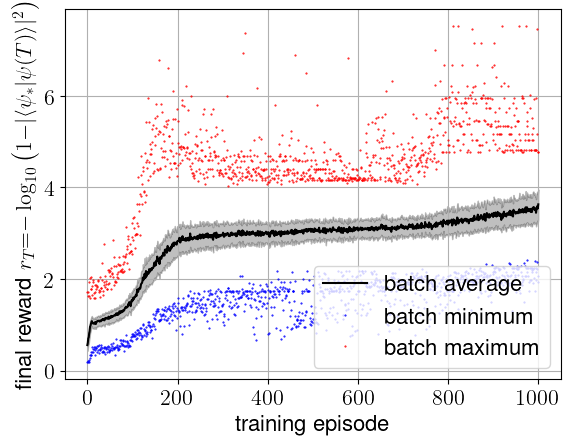

In [12]:
import matplotlib
from matplotlib import pyplot as plt

# import plotting tool
plt.rcParams.update({
    "text.usetex": True, # enable latex font
    "font.family": "Helvetica", # set font style
    "text.latex.preamble": r'\usepackage{amsmath}', # add latex packages
    "font.size": "16", # set font size
})

# static plots
%matplotlib inline 

### plot and examine learning curves

episodes=list(range(N_episodes))

plt.plot(episodes, mean_final_reward, '-k', label='batch average' )
plt.fill_between(episodes, 
                 mean_final_reward-0.5*std_final_reward, 
                 mean_final_reward+0.5*std_final_reward, 
                 color='k', 
                 alpha=0.25)

plt.plot(episodes, min_final_reward, '.b' , markersize=1, label='batch minimum' )
plt.plot(episodes, max_final_reward, '.r' , markersize=1, label='batch maximum' )

plt.xlabel('training episode')
plt.ylabel('final reward $r_T{=}{-}\\log_{10}\\left(1{-}|\\langle\\psi_\\ast|\\psi(T)\\rangle|^2\\right) $')

plt.legend(loc='lower right')
plt.grid()
plt.show()

# np.savez('PG-STA_training',
#               episodes=episodes, 
#               mean_final_reward=mean_final_reward, 
#               std_final_reward=std_final_reward, 
#               min_final_reward=min_final_reward,
#               max_final_reward=max_final_reward,
#          )

In [ ]:
env.reset()
RL_field_t = np.zeros(env.n_time_steps)
RL_actions_t = np.zeros(env.n_time_steps, dtype=int)
fidelity_t = np.zeros(env.n_time_steps)
fidelity_inst_t = np.zeros(env.n_time_steps)

for time_step in range(env.n_time_steps):
    #print('time step {0:d}'.format(time_step) )
    # select state
    state[:] = env.state[:]
    CD_drive=env.CD_drive
    
    # select an action according to current policy
    pi_s = np.exp( predict(current_params, state) )
    action = np.argmax(pi_s)
    #action = np.random.choice(env.actions, p = pi_s)
    #print('policy:', pi_s, np.argmax(pi_s))

    #action = RL_best_seen_actions[time_step]
    
    # record field value
    RL_field_t[time_step] = CD_drive + env.delta_h*env.action_space[action]
    RL_actions_t[time_step] = env.action_space[action]

    #print(CD_drive, env.delta_h*env.action_space[action])
    
    # take an environment step
    state[:], reward, _ = env.step(action)

    # measure target fidelity
    fidelity_t[time_step] = np.abs( env.psi_target.conj().dot(env.psi)  )**2 #reward

    # measure instantaneous fidelity
    drive = env.h_t(env.dt*env.ep_step)
    H = env.Delta*env.sigma_z + drive*env.sigma_x
    E_inst,V_inst = np.linalg.eigh(H)
    psi_inst=V_inst[:,0]

    fidelity_inst_t[time_step] = np.abs( psi_inst.conj().dot(env.psi)  )**2 #reward

reward_RL = reward

print('RL fidelity:', fidelity_t[-1])

plt.step(times, fidelity_t, '.-k', where='pre')
plt.step(times, fidelity_inst_t, '.-', color='brown', where='pre')

plt.step(times, CD_protocol_t, '.-b', where='pre', label='discretized CD, $r_T={0:0.3f}$'.format(reward_CD_approx) )
plt.step(times, RL_field_t, '.-g', where='pre', label='RL agent, $r_T={0:0.3f}$'.format(reward_RL) )
plt.plot(times, exact_CD_protocol(times),'--r', label='exact CD, $r_T=\\infty$' )

plt.legend(fontsize=14)
plt.xlabel('time $t$')

plt.show()

# np.savez('PG-STA_protocol',
#               times=times, 
#               fidelity_t=fidelity_t, 
#               fidelity_inst_t=fidelity_inst_t, 
#               RL_field_t=RL_field_t, 
#               CD_protocol_t=CD_protocol_t,
#               exact_CD_protocol=exact_CD_protocol(times),
#               reward_RL=reward_RL,
#               reward_CD_approx=reward_CD_approx,
#          )

## Questions

**Q0.** Try out different batch sizes and hyperparameters (including different network architectures). Can you improve the performance?

**Q1.** Reducing the time step size while keeping the protocol duration fixed will increase the total number of steps in an episode. Does the RL agent find the exact CD protocol in this case?

**Q2.** The current problem limits the RL agent to control the $\sigma^y$ term only; add a second set of actions to also optimize the control field of the $\sigma^x$ term simultaneously. You may need to run a new hyperparameter search. 